In [1]:
import cpuinfo
cpuinfo.get_cpu_info()['brand']

'Intel Xeon Processor (Skylake, IBRS)'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15925543373770702547, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7302731545365684373
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14932943525986467211
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14784631459705184496
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:02.0, compute capability: 6.0"]

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
import imageio
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import seaborn as sns

In [6]:
%run ../utils/unet.py
%run ../utils/helpers.py
%run ../utils/generate_flat_bg.py
%run ../utils/generate_bg.py
%run ../utils/generate_train_set.py

Using TensorFlow backend.


In [7]:
h_size = 256
w_size = 256
start_neurons = 16
mask_pool_size = 1000
train_num = 1000
bg_admix_iters = 5

cores_count = mp.cpu_count()
cpu_pool = mp.Pool(processes=cores_count)

In [8]:
train_x = np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = np.zeros((train_num, h_size, w_size, 1), dtype='float32')

model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
sample_img = imageio.imread('../data/train/original_sample_blur_1000.jpg', pilmode="RGB")
mask_img = imageio.imread('../data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)

In [10]:
simplest_flat_bg = imageio.imread('../data/train/simplest_flat_bg.jpg', pilmode="RGB")
simple_bg = imageio.imread('../data/train/simplest_bg.jpg', pilmode="RGB")

In [11]:
mask_pool = [
    get_mask(h_size, w_size) 
    for _ in tqdm(range(mask_pool_size))
]

100%|██████████| 1000/1000 [00:37<00:00, 27.00it/s]


In [12]:
# %%time
# for k in range(train_num): # tqdm
#     img, msk = next_pair(
#         original_mask,
#         original_smpl,
#         simplest_flat_bg,
#         simple_bg,
#         mask_pool,
#     )
#     train_x[k] = img
#     train_y[k] = msk

In [13]:
%%time
coros = [
    cpu_pool.apply_async(
        next_pair, 
        args=(
            original_mask,
            original_smpl,
            simplest_flat_bg,
            simple_bg,
            mask_pool,
        )
    ) 
    for _ in range(train_num)
]
k = 0
for img, msk in [p.get() for p in coros]:
    train_x[k] = img
    train_y[k] = msk
    k += 1

CPU times: user 11.5 s, sys: 39 s, total: 50.5 s
Wall time: 1min 6s


In [14]:
acc = []
val_acc = []
for _ in range (50):
    history = model.fit(train_x, train_y,
                        batch_size=32,
                        epochs=1,
                        verbose=1,
                        validation_split=0.1
                       )    
    acc_ = history.history['my_iou_metric'][0]
    val_acc_ = history.history['val_my_iou_metric'][0]
    acc.append(acc_)
    val_acc.append(val_acc_)
    if acc_ > 0.99:
        break

Instructions for updating:
Use tf.cast instead.
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 6s 67ms/step - loss: 1.3625 - my_iou_metric: 0.0044 - val_loss: 1.1688 - val_my_iou_metric: 0.0000e+00
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 8ms/step - loss: 1.3493 - my_iou_metric: 0.0000e+00 - val_loss: 1.1954 - val_my_iou_metric: 0.0000e+00
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 8ms/step - loss: 1.3452 - my_iou_metric: 0.0000e+00 - val_loss: 1.1963 - val_my_iou_metric: 0.0000e+00
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 8ms/step - loss: 1.3286 - my_iou_metric: 0.0000e+00 - val_loss: 1.1886 - val_my_iou_metric: 0.0000e+00
Train on 90 samples, validate on 10 samples
Epoch 1/1
90/90 [==============================] - 1s 7ms/step - loss: 1.3281 - my_iou_metric: 0.0000e+00 -

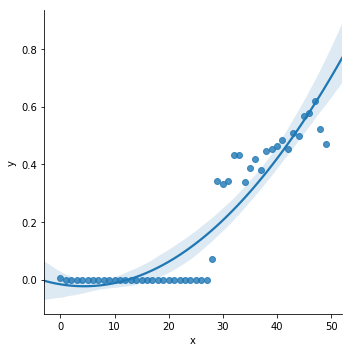

In [15]:
df = pd.DataFrame({'x': list(range(len(acc))), 'y': acc})
sns.lmplot(x="x", y="y", data=df, order=2);

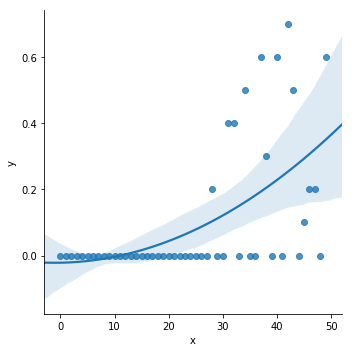

In [16]:
df = pd.DataFrame({'x': list(range(len(val_acc))), 'y': val_acc})
sns.lmplot(x="x", y="y", data=df, order=2);